# Exploratory Analysis

I choose the simplest application with the nutriscore : Predict it for non-label aliments. My main question will be about the robustess of my missing data inference. I read about this score [on this official document](https://www.santepubliquefrance.fr/media/files/02-determinants-de-sante/nutrition-et-activite-physique/nutri-score/qr-scientifique-technique) (on "sante public france" [website](https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/articles/nutri-score))

In [1]:
data_path = "/home/clairegayral/Documents/openclassroom/data/"

# On importe les librairies dont on aura besoin pour ce tp
import numpy as np
import pandas as pd
import sklearn
## plot : 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 5]
import seaborn as sns
## stat / model : 
from sklearn.model_selection import train_test_split

import itertools as IT

In [2]:
data = pd.read_csv(data_path+"projet2/cleanned_dataframe.csv",  index_col =0)
data_std = pd.read_csv(data_path+"projet2/cleanned_std_dataframe.csv",  index_col =0)

# 1. Nutri-score analysis : 

# 1.1 Univariate analysis : Nutri-score as a numerical variable

Let's first see the description statistics on the variable : 

In [3]:
y = data["nutrition-score-fr_100g"].copy()
y.describe()

count    9969.000000
mean        9.115558
std         8.883424
min       -14.000000
25%         1.000000
50%        10.000000
75%        16.000000
max        37.000000
Name: nutrition-score-fr_100g, dtype: float64

So it takes values between {{min(y)}} and {{max(y)}}, it is well-centered : the mean (={{y.mean()}}) is close to the median value (={{y.quantile(0.5)}}

Text(0.5, 1.0, 'nutrition-score')

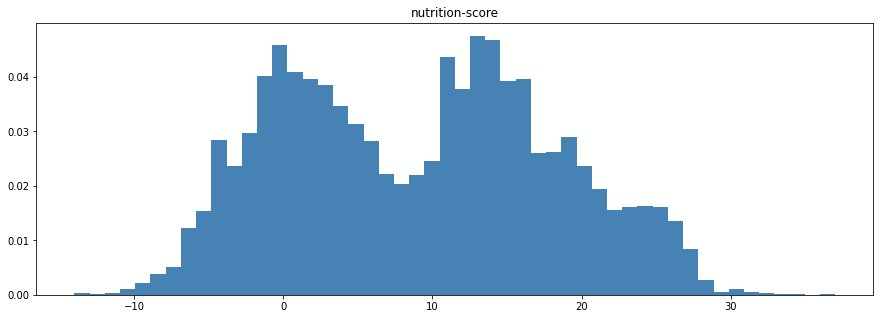

In [4]:
nb_bins = len(np.unique(y.dropna().values))
plt.hist(y, bins = nb_bins, color='steelblue', density=True, edgecolor='none')
plt.title("nutrition-score")

This varible as both negative and positive values, but I still look at the Lorenz curve and AUC, after rescaling y with a min-translatation : 

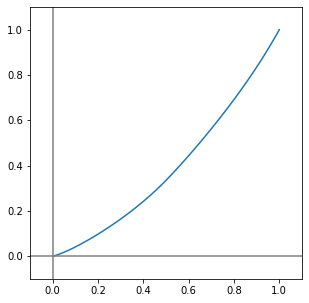

In [5]:
## lorenz curve : 
import numpy as np

n = len(y)
y_rescaled = y - min(y)
lorenz = np.cumsum(np.sort(y_rescaled)) / y_rescaled.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

fig, ax = plt.subplots()

ax.axis('scaled')
xaxis = np.linspace(0-1/n,1+1/n,n+1) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.plot([0,0],[-0.1,1.1], color="grey") # y axis 
plt.plot([-0.1,1.1],[0,0], color="grey") # x axis

plt.show()

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S

The AUC is {{np.round(AUC,2)}}, that means that ... .
Futhermore, the gini indice is {{np.round(gini,2)}}

**write the interpretation + solve affichage variable in markedown**
https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4730366-familiarisez-vous-avec-les-mesures-de-concentration

## 1.2 Qualitative data :

Now, the document allow us to transform this score variable into the corresponding score letter : 

In [6]:
tmp = pd.DataFrame(columns = ["score","min_liquide","max_liquide","min_solide","max_solide"])
tmp["score"] = ["A", "B", "C", "D", "E"]
tmp["min_liquide"] = [np.nan,-100,2,6,10]
tmp["max_liquide"] = [np.nan, 1, 5, 9, 100]
tmp["min_solide"] = [-100,0,3,11,19]
tmp["max_solide"] = [-1,2,10,18,100]
tmp.score = tmp.score.astype("category")

tmp.dtypes

score          category
min_liquide     float64
max_liquide     float64
min_solide        int64
max_solide        int64
dtype: object

As the nature (liquide or solid) of the product is a main element to determine that score, it would be better to **find a way to classify liquid and solid products**
I think that is a property we may deduce from the text description variable, and I do not have the time for this project to go that far. So I'll just compute the letter corresponding to solid scores, as an approximation. 

In [7]:
# ref_table = pd.DataFrame({"score":["A", "B", "C", "D", "E"],
#                           "min_val":[-100,0,3,11,19], 
#                           "max_val":[-1,2,10,18,100]}, dtype = "float")
# ref_table.score = tmp.score.astype("category")

def transform_score_letter(product_score):
    ref_max = pd.Series([-1,2,10,18,100], 
                        index=["A", "B", "C", "D", "E"],
                        dtype = "float")
    return(ref_max[(product_score <= ref_max)].index[0])

letter_score = [transform_score_letter(y.iloc[i]) for i in range(len(y))]
letter_score = pd.Series(letter_score, dtype="category", index = y.index, name="score")

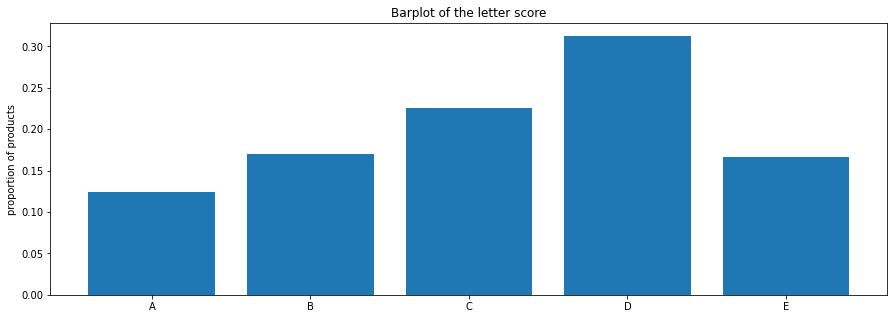

In [8]:
letter_count = letter_score.value_counts()/letter_score.count()
labels = ['A', 'B', 'C', 'D', 'E']
plt.bar(labels, letter_count[labels])
plt.title("Barplot of the letter score")
plt.ylabel("proportion of products")
plt.show()

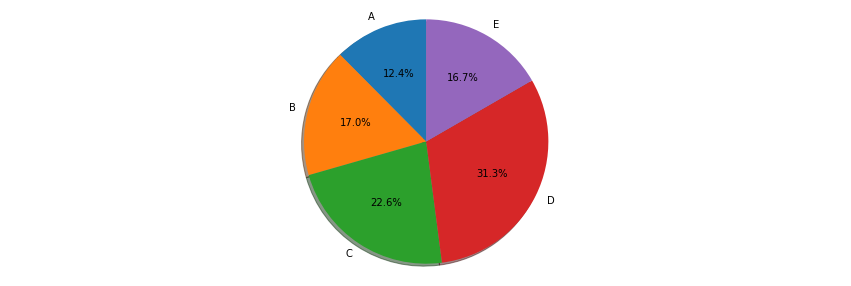

In [9]:
fig1, ax1 = plt.subplots()
ax1.pie(letter_count[labels], #explode=0.1*np.ones(len(labels)),
        labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Let's integrate this categorical information to our numerical data :

In [10]:
description_var = ['code', 'countries', 'creator', 'product_name']
float_var = ['additives_n', 'ingredients_from_palm_oil', 'energy-kcal_100g',
             'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g',
             'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g',
             'fiber_100g', 'proteins_100g', 'sodium_100g', 'vitamin-a_100g',
             'vitamin-c_100g', 'calcium_100g', 'iron_100g',
             'nutrition-score-fr_100g']
data = pd.concat([letter_score, data[data.columns.intersection(float_var)]], axis = 1)
data.head()

,score,additives_n,ingredients_from_palm_oil,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
246189,D,0.0,3.469447e-18,560.0,2343.0,44.00,24.00,0.0,0.000,52.00,36.00,12.00,8.0,0.012,0.000013,0.00450,0.08000,7.200000e-03,18.0
320939,C,0.3,3.469447e-18,368.0,1540.0,8.80,0.80,0.0,0.000,65.00,53.00,6.18,6.8,0.080,0.000182,0.01501,0.06930,3.105000e-03,5.0
191348,D,5.0,3.469447e-18,419.0,1753.0,35.48,4.84,0.0,0.048,22.58,19.35,0.00,0.0,0.484,0.000000,0.00000,0.00000,-2.168404e-19,18.0
331844,D,0.0,3.469447e-18,900.0,3766.0,100.00,11.00,0.0,0.000,0.50,0.50,0.00,0.5,0.004,0.000010,0.00000,0.00072,3.000000e-07,11.0
189487,D,1.0,3.469447e-18,367.0,1536.0,40.00,5.00,0.0,0.000,3.33,0.00,0.00,0.0,0.967,0.000061,0.00160,0.13300,2.000000e-04,18.0


# 2. Dimension Reduction 
## 2.1 Correlation Matrix :
Let us first of all see if the variable are correlated : 

In [11]:
def plot_corr_heatmap(corr): 
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

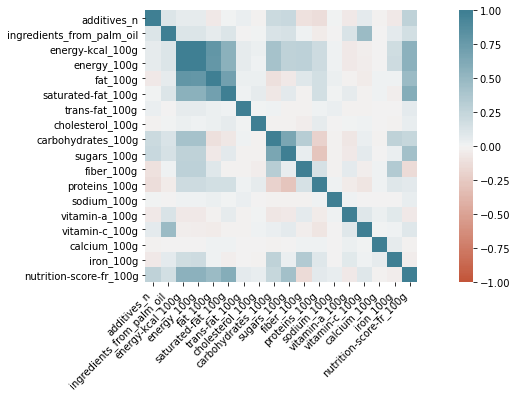

In [12]:
corr = data.corr()
plot_corr_heatmap(corr)

Let's sort the correlation index by the values in the nutrition score : 

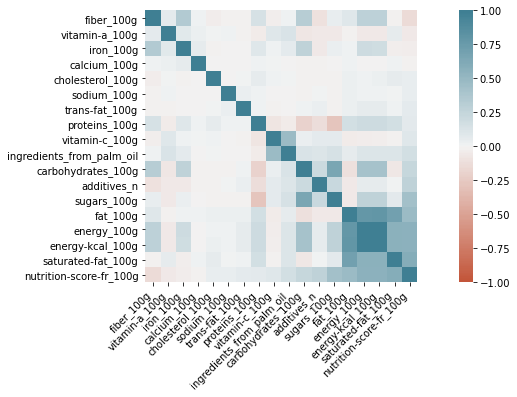

In [13]:
sorted_corr = corr.sort_values(by="nutrition-score-fr_100g", ascending = True)
sorted_corr = sorted_corr.sort_values(by="nutrition-score-fr_100g", axis = 1, ascending = True)
plot_corr_heatmap(sorted_corr)

There seems to be a cluster of correlated variable conserning fat and energy, and the other variables does not seem so correlated. If it's the case, computing a PCA. 
Note that most of this code is an adapation of [the TP code proposed in the OC class](https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees/5345201-tp-realisez-une-acp). 

In [14]:
from functions import *
from sklearn import decomposition
from sklearn import preprocessing

# choix du nombre de composantes à calculer
n_comp = 6

# selection des colonnes à prendre en compte dans l'ACP
X = data.drop(["score","nutrition-score-fr_100g"],axis = 1, inplace = False)

# préparation des données pour l'ACP
scores = np.intc(data["nutrition-score-fr_100g"]) # ou data.index pour avoir les intitulés
features = data.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

Let's see the explained variance each new component brings : 

In [15]:
##################################################

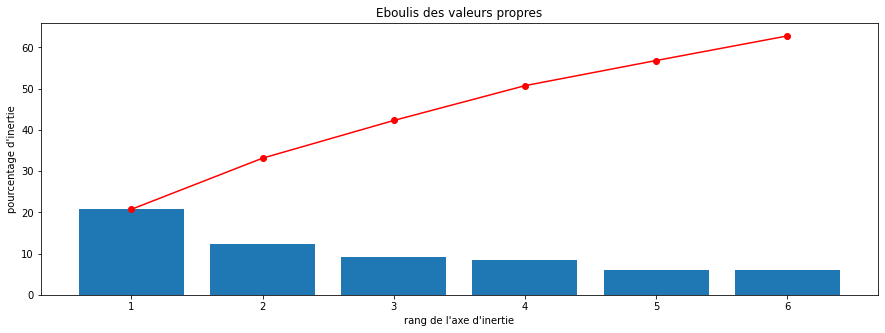

In [16]:
# Eboulis des valeurs propres
display_scree_plot(pca)

The first axe explaines 20% of the variance, and the second 12.5%. That is really low, I think that it's relevant to use our knowlegde about the cluster of "fat" variables to gather them before doing the global pca. 

To be sure, let's see the correlation circle and the projected cloud of the products in the two firsts axis :

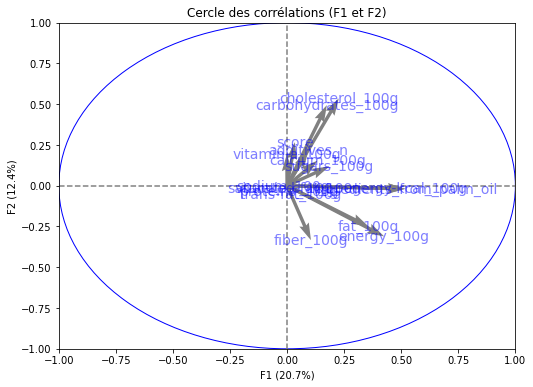

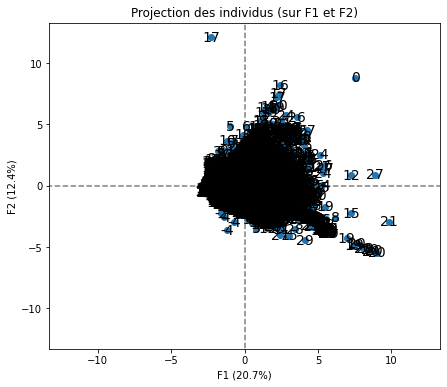

In [17]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, 2, pca, [(0,1)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, 2, pca, [(0,1)], labels = np.array(scores))
plt.show()

In [18]:
# pcs = pd.DataFrame(pcs, index = ["Axis"+ str(k) for k in np.arange(1,n_comp+1)],
#              columns=X.columns)
# X_projected = pd.DataFrame(X_projected, index = X.index, columns = ["Axis"+ str(k) for k in np.arange(1,n_comp+1)])

It is hard to distinguish the too close variables. I go back to my idea of a hierarchical clustering on variables to first gather the ones with same comportement. Same as before, I mostly adapt the code from [the corresponding OC course](https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees/5345241-tp-partitionnez-vos-donnees).

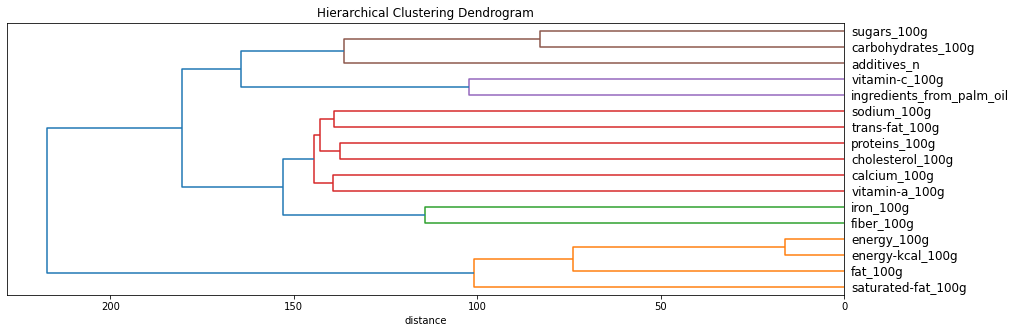

In [19]:
from scipy.cluster.hierarchy import linkage, fcluster

# Clustering hiérarchique
Z = linkage(X_scaled.transpose(), 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, X.columns, figsize = (15,5))

I modified the function to draw pca corr circle, so that I can put some clustering colors on the arrows, and print the corresponding legend : 

In [141]:
def get_str_vars(list_of_var):
    # from a list of str, return a sentence
    # if the line is too long (sup to 40), cut
    tmp = list_of_var.copy()
    res = ""
    len_line = 0
    while tmp : 
        var = tmp.pop()
        res = res+ var +str(", ")
        len_line += len(var)
        if len_line > 40:
            res = res +"\n"
            len_line = 0
    return(res)

def draw_cluster_legend(ax2,clustering, corresp_color_dict):
    ## plot the legend with colored arrow
    # number of clusters : 
    K = len(clustering.values.categories)
    my_color = clustering.values.categories.map(corresp_color_dict)
    # plot parallel arrows :
    ax2.quiver(np.zeros(K),np.arange(0,K),np.ones(K),np.zeros(K),
               color = my_color)
    # plot legend text next to the respective arrow :
    for k in clustering.values.categories :
        cluster_var = get_str_vars(list(clustering[clustering == k].index.values))
        ax2.text(0.2, k , str(cluster_var), fontsize='11',
                 ha='left', va='center' , alpha=1)
    # set limits : 
    ax2.set_xlim([-0.1,2])
    ax2.set_ylim([-1.1, K+0.1])
    ax2.set_title("Clustering legend")
    # remove axis :
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    plt.axis("off")
    return(ax2)

# fig2, ax2 = plt.subplots(1,1)
# draw_cluster_legend(ax2, cluster)
# plt.show()

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None, clustering = None):
    ## set coloration palette : 
    if clustering is not None : 
        my_color_set = ['#154406', '#15b01a', '#fffd01', '#f97306', '#c0022f',
                '#0343df', '#fe02a2', '#8b3103', '#7e1e9c', '#017371',
                '#380282', '#6b8ba4', '#75bbfd', '#ff81c0', '#c79fef',
                '#ff073a', '#fdaa48', '#fea993', '#fe7b7c', '#c20078',
                '#029386', '#677a04', '#b25f03', '#070d0d']
        corresp_color_dict = dict(zip(clustering.values.categories, my_color_set))
        my_color = clustering.values.map(corresp_color_dict)

    else : 
        my_color = "grey"
    ## set global plot arguments : 
    plot_kwargs = {"alpha":1, "color":my_color}
    ## draw the correlation circle for pca : 
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:
            ## initialise figure
            if clustering is not None : 
                fig = plt.figure(figsize = (18,6))
                ## affichage de la legende du clustering en couleur : 
                ax2 = fig.add_subplot(1,2,2)
                draw_cluster_legend(ax2, clustering, corresp_color_dict)
                # initialisation de la figure "cercle"
                ax1 = fig.add_subplot(1,2,1)
            else : 
                fig = plt.figure(figsize = (9,6))
                ax1 = fig.add_subplot(1,1,1)

            ## détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            ## affichage des fleches :
            if pcs.shape[1] < 30 :
                ax1.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]), ## depart points
                           pcs[d1,:], pcs[d2,:], ## movement in each direction
                           angles='xy', scale_units='xy',**plot_kwargs)
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else: # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax1.add_collection(LineCollection(lines, axes=ax, alpha=.1, color=my_color))

            ## affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        ax1.text(x, y, labels[i], fontsize='14', ha='center', 
                                 va='center', rotation=label_rotation, color="blue", alpha=0.5)

            ## affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            ## définition des limites du graphique
            ax1.set_xlim(xmin, xmax)
            ax1.set_ylim(ymin, ymax)

            ## affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            ## nom des axes, avec le pourcentage d'inertie expliqué
            ax1.set_xlabel('F{} ({}%)'.format(d1+1, 
                                round(100*pca.explained_variance_ratio_[d1],1)))
            ax1.set_ylabel('F{} ({}%)'.format(d2+1, 
                                round(100*pca.explained_variance_ratio_[d2],1)))
            ax1.set_title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
    plt.show(block=False)

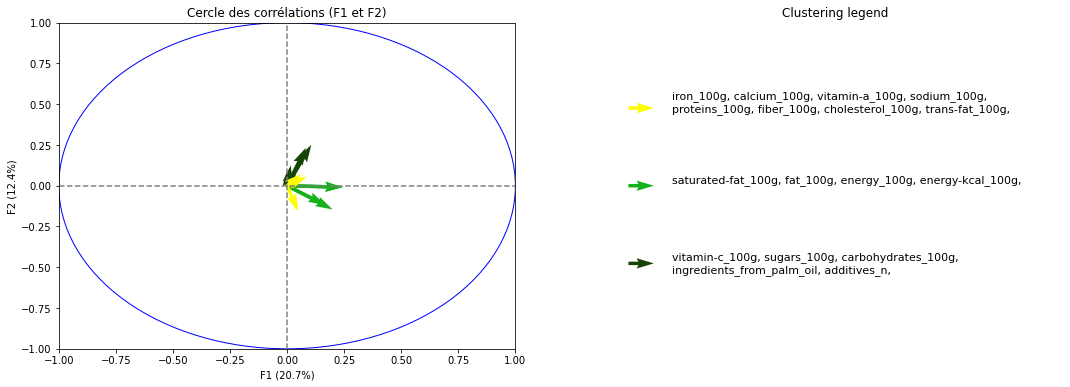

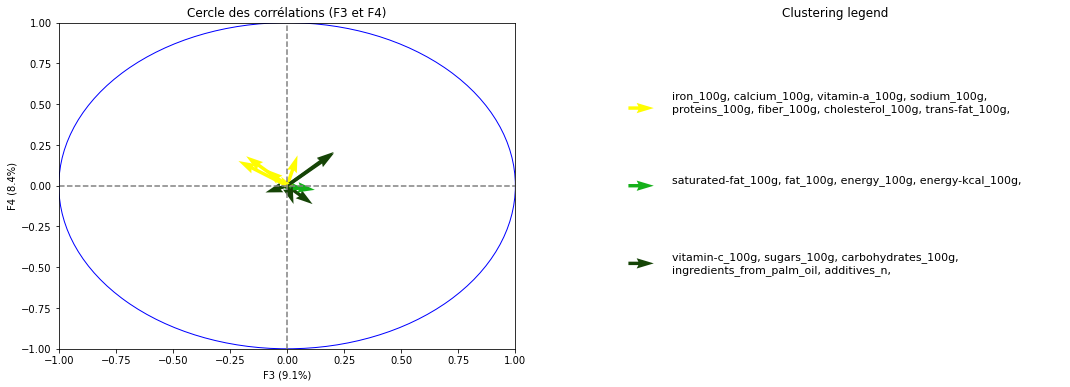

In [144]:
from scipy.cluster.hierarchy import cut_tree
import matplotlib._color_data as mcd
import random

clustering = pd.Series(cut_tree(Z, height=170).T[0], index=X.columns, dtype="category")
pcs = pca.components_

display_circles(pcs, 4, pca, [(0,1), (2,3)], labels = None, clustering=clustering)


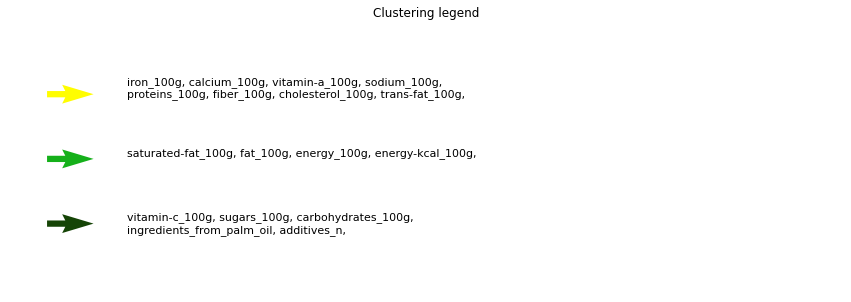

In [145]:
def draw_cluster_legend(ax2,clustering, corresp_color_dict):
    ## plot the legend with colored arrow
    # number of clusters : 
    K = len(clustering.values.categories)
    my_color = clustering.values.categories.map(corresp_color_dict)
    # plot parallel arrows :
    ax2.quiver(np.zeros(K),np.arange(0,K),np.ones(K),np.zeros(K),
               color = my_color)
    # plot legend text next to the respective arrow :
    for k in clustering.values.categories :
        cluster_var = get_str_vars(list(clustering[clustering == k].index.values))
        ax2.text(0.2, k , str(cluster_var), fontsize='11',
                 ha='left', va='center' , alpha=1)
    # set limits : 
    ax2.set_xlim([-0.1,2])
    ax2.set_ylim([-1.1, K+0.1])
    ax2.set_title("Clustering legend")
    # remove axis :
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    plt.axis("off")
    return(ax2)

fig2, ax2 = plt.subplots(1,1)
clustering = pd.Series(cut_tree(Z, height=170).T[0], index=X.columns, dtype="category")

my_color_set = ['#154406', '#15b01a', '#fffd01', '#f97306', '#c0022f',
                '#0343df', '#fe02a2', '#8b3103', '#7e1e9c', '#017371',
                '#380282', '#6b8ba4', '#75bbfd', '#ff81c0', '#c79fef',
                '#ff073a', '#fdaa48', '#fea993', '#fe7b7c', '#c20078',
                '#029386', '#677a04', '#b25f03', '#070d0d']

corresp_color_dict = dict(zip(clustering.values.categories, my_color_set))



draw_cluster_legend(ax2, clustering, corresp_color_dict)
plt.show()


In [146]:
clustering.values.map(corresp_color_dict)

['#154406', '#154406', '#15b01a', '#15b01a', '#15b01a', ..., '#fffd01', '#fffd01', '#154406', '#fffd01', '#fffd01']
Length: 17
Categories (3, object): ['#154406', '#15b01a', '#fffd01']

Now, let's focus on the projection of individuals onto the pca axis. In the same way, I wan to be able to put a clustering/a coloration on this plot. In deed, it would be a good way to see if in this projection, the nutri-score is well separated (it may not be at all, seeing the correlation heatmap).

In [ ]:
# Projection des individus
display_factorial_planes(X_projected, 2, pca, [(0,1)], labels = None)
plt.show()

**problem with the legend :**
+ couleurs dans le clustering ?

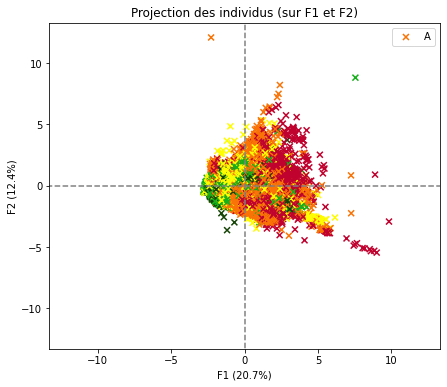

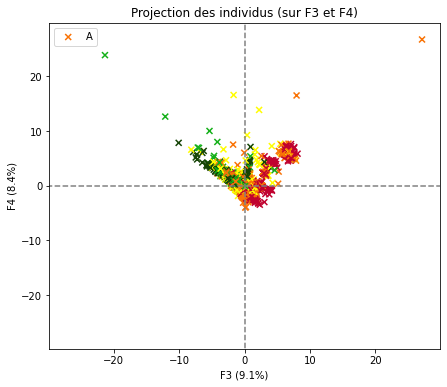

In [148]:
# X_projected
n_comp = 4
# pca
axis_ranks =  [(0,1), (2,3)]
ind_labels=None
alpha=1 
illustrative_var="additive_n"
clustering = data["score"]

X_projected = pca.transform(X_scaled)
X_projected = pd.DataFrame(X_projected, index = X.index, 
                           columns = ["Axis"+ str(k) for k in np.arange(1,X_projected.shape[1]+1)])

def display_factorial_planes_pb_legend(X_projected, n_comp, pca, axis_ranks, ind_labels=None, alpha=1):
    plot_kwargs = {"marker":"x", "alpha":alpha}#, "label" : clustering.values.categories}

    if clustering is not None : 
        my_color_set = ['#154406', '#15b01a', '#fffd01', '#f97306', '#c0022f', '#0343df', '#fe02a2', '#8b3103', 
                    '#7e1e9c', '#017371', '#380282', '#6b8ba4', '#75bbfd', '#ff81c0', '#c79fef', '#ff073a', 
                    '#fdaa48', '#fea993', '#fe7b7c', '#c20078', '#029386', '#677a04', '#b25f03', '#070d0d']
        corresp_color_dict = dict(zip(clustering.values.categories, my_color_set))
    #     my_color = clustering.values.map(corresp_color_dict)
        plot_kwargs["color"] = clustering.values.map(dict(zip(clustering.values.categories, my_color_set)))

    for d1,d2 in axis_ranks:
        if d2 < n_comp:
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))

            plt.scatter(X_projected.values[:, d1], X_projected.values[:, d2], **plot_kwargs)
            plt.legend(clustering.values.categories)

            # affichage des labels des points
            if ind_labels is not None:
                for i,(x,y) in enumerate(X_projected.values[:,[d1,d2]]):
                    plt.text(x, y, ind_labels[i],
                              fontsize='14', ha='center',va='center') 

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected.values[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
display_factorial_planes_pb_legend(X_projected, n_comp, pca, axis_ranks, ind_labels=None, alpha=1)

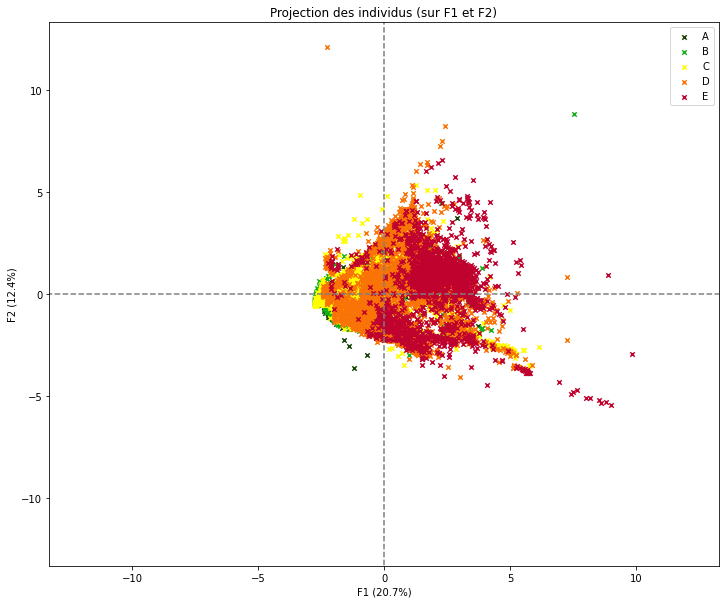

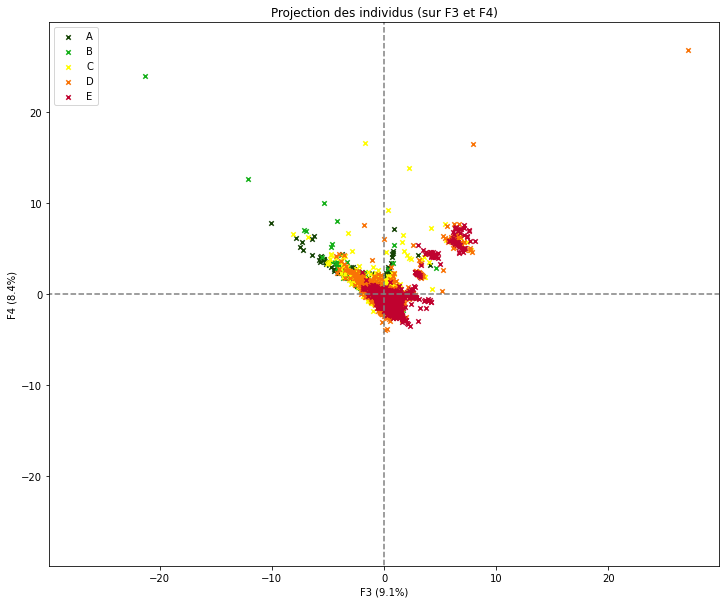

In [150]:
X_projected = pca.transform(X_scaled)
X_projected = pd.DataFrame(X_projected, index = X.index, 
                           columns = ["Axis"+ str(k) for k in np.arange(1,X_projected.shape[1]+1)])
n_comp = 4
# pca = 
axis_ranks =  [(0,1), (2,3)]
ind_labels=None
alpha=1
illustrative_var="additive_n"
clustering = data["score"]


def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, ind_labels=None, alpha=1, clustering = None):
    # args are as defined just above 
    plot_kwargs = {"marker":"x", "alpha":alpha, 's':20}#, "label" : clustering.values.categories}
    # set dict of color if clustering : 
    if clustering is not None : 
        my_color_set = ['#154406', '#15b01a', '#fffd01', '#f97306', '#c0022f', '#0343df', '#fe02a2', '#8b3103', 
                    '#7e1e9c', '#017371', '#380282', '#6b8ba4', '#75bbfd', '#ff81c0', '#c79fef', '#ff073a', 
                    '#fdaa48', '#fea993', '#fe7b7c', '#c20078', '#029386', '#677a04', '#b25f03', '#070d0d']
        corresp_color_dict = dict(zip(clustering.values.categories, my_color_set))

    for d1,d2 in axis_ranks:
        if d2 < n_comp:
            ax1 = "Axis"+ str(d1+1)
            ax2 = "Axis"+ str(d2+1)
            # initialisation de la figure       
            fig = plt.figure(figsize=(12,10))
            if clustering is not None :
                for k in clustering.values.categories:
                    cluster_index = clustering[clustering==k].index
    #                 print(X_projected.loc[cluster_index, ax1])
                    plt.scatter(X_projected.loc[cluster_index, ax1],X_projected.loc[cluster_index, ax2], 
                                color=corresp_color_dict[k], label = k, **plot_kwargs)
                    plt.legend()

            else : 
                plt.scatter(X_projected[ax1], X_projected[ax2], **plot_kwargs)
            # affichage des labels des points
            if ind_labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, ind_labels[i],
                              fontsize='14', ha='center',va='center') 

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected.values[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
display_factorial_planes(X_projected, n_comp, pca, axis_ranks, ind_labels=None, alpha=1)

In [ ]:
data